In [1]:
################## IMPORT LIBRARIES ##################
from IPython.display import Audio
import numpy as np
import sys
import importlib
import random 
import pandas as pd
pd.options.mode.copy_on_write = True
from IPython.display import Audio
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch
from IPython.display import display, Image

In [6]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)

/home/ubuntu/Data/joanna-venvs/wave-u-net2/lib/python3.8/site-packages/df/io.py:9: UserWarning: `torchaudio.backend.common.AudioMetaData` has been moved to `torchaudio.AudioMetaData`. Please update the import path.
  from torchaudio.backend.common import AudioMetaData


<module 'models' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/models.py'>

# DEMO OF OUR ACOUSTIC MATCHING ALGORITHM 

<img src="../demo_images/problem1.png" alt="Problem Image" width="600" height="450">

##### Imagine you are having a meeting in AR. Your conversation partner is represented as an avatar, but in reality she is somewhere else...

- #### Motivation: If we add a sound in AR, we want it to match with the local soundscape.
- #### Problem: Every user is located in acoustically different space - the acoustic properties will differ.
- #### Proposed solution: Algorithm for modifying the acoustics properties of a sound. 
- #### Why is it a challenge: Traditionally this is solved using several sub-tasks:
    - de-reverberation
    - room impulse response estimation
    - convolution
- #### Our algorithm : All-in-one ;-)




<img src="../demo_images/network.png" alt="Problem Image" width="600" height="450">

### How does it work? 
- #### Inputs: 
    1) Sound that we want to modify (s1r1)
    2) Sound defining our desired acoustic space (s2r2)
- #### Output: 
    1) Original sound with a modified acoustics (s1r2)
- #### In-between: 
    1) Reverb encoder - a network which extracts room info from the signal (z1)
    2) Wave-u-net autoencoder conditioned on the room info

In [21]:
################## LOAD TRAINING RESULTS AND CONFIG  ##################

datapath="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/"
exp_tag="runs-exp-20-05-2024"
#train_tag="20-05-2024--22-48_c_wunet_logmel+wave_0.8_0.2"
train_tag="10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2"

config ,train_results = trainer.load_train_results(datapath, exp_tag, train_tag,configtype="yaml")

# instantiate a test data set 
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/nonoise_48khz_guestxr.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)

# load training weights
model=trainer.load_chosen_model(config,config["modeltype"])
model.load_state_dict(train_results["model_state_dict"])


/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/trainer.py:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_results=torch.load(pjoin(datapath,exp_tag,tr

<All keys matched successfully>

In [111]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC RT60 VALUES   ##################

task="reverb2dry"
# task="dry2reverb"

if task=="reverb2dry":
    chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(-0.8,-0.6)
    chosen_rt60_idx_list=[1835,4051,706,67,5699,740]
elif task=="dry2reverb":
    chosen_rt60_idx_list=dataset.get_idx_with_rt60diff(0.6,0.8)
    chosen_rt60_idx_list=[6417,6786,3151,4323,3534,265]

In [112]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

dp=chosen_rt60_idx_list[random.randint(0, len(chosen_rt60_idx_list) - 1)]
sContent,sStyle,sTarget,sPrediction=trainer.infer(model,dataset[dp],config["device"])
if bool(config["is_vae"]):
    sPrediction, _, _ = sPrediction

sContent:


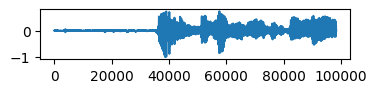

sStyle:


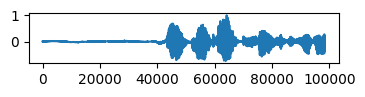

sTarget:


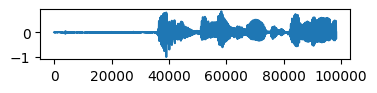

sPrediction:


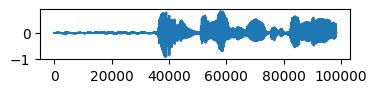

In [110]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sTarget, sPrediction]
names=["sContent", "sStyle", "sTarget", "sPrediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1) 
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    # wavfile.write("sounds/dp_"+str(dp)+"_"+names[i]+".wav", int(48e3), audio.numpy())
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))